In [23]:
%run gen_cv.py


Building Trie..., from /home/joekaojoekao/github/dict.txt.big
DEBUG:jieba:Building Trie..., from /home/joekaojoekao/github/dict.txt.big
loading model from cache /tmp/jieba.user.8815186977980235228.cache
DEBUG:jieba:loading model from cache /tmp/jieba.user.8815186977980235228.cache
loading model cost 3.02387714386 seconds.
DEBUG:jieba:loading model cost 3.02387714386 seconds.
Trie has been built succesfully.
DEBUG:jieba:Trie has been built succesfully.


read source: ./visualized/select_pushes1000_1.txt
Pushes filtering (keep only pushes larger than 4 words)
After filtering / Origin push num:  999 / 999
Users filtering (remove users who post less than 3 pushes)
After filtering / Previous user num:  718 / 999
write user list: ./temp/select_pushes1000_1_userlist.txt
write push data ready to do cross_validation: ./temp/select_pushes1000_1_cvlist.txt


In [236]:
%%pypy
import numpypy as np # while at sweslos' centos6.x

## using pypy magic needs a temp file for output 
import json
import time
import math
import os


def count_dict(sample_dict_jieba):
    from collections import Counter
    from collections import OrderedDict
    import itertools
    ptt_pushes_freq_bypush = {}
    for uid, push_list in sample_dict_jieba.iteritems():
        push = push_list[0] #raw push
        a = zip(*push_list)[1] #jieba ones
        push_gram = list(itertools.chain(*a))
        count = Counter(push_gram)
        temp = []
        for w, c in count.most_common():
            temp.append((w, c))
        id_count = Counter(dict(temp))
        ptt_pushes_freq_bypush[uid] = dict(id_count)

    return ptt_pushes_freq_bypush

def weighted_jaccard(l1, l2):
    if len(l1) != len(l2):
        return -1
    num = 0
    den = 0
    for i in xrange(len(l1)):
        num += np.minimum(l1[i], l2[i])
        den += np.maximum(l1[i], l2[i])
    wj = np.divide(np.float64(num), den+1)

    return wj

import os
dir_path = os.getcwd() + '/'
with open(dir_path + 'config.txt', 'rb') as f_conf:
    config = json.load(f_conf)
    f_conf.close()
    
sample_file = config["sample_file"] #first input
temp_path = config["temp_path"] 
result_dir = config["result_dir"]

## just pick some user here from temp folder
with open(temp_path + os.path.splitext(sample_file)[0] + '_userlist.txt', 'rb') as f_temp:
    print 'read user from ', temp_path + os.path.splitext(sample_file)[0] + '_userlist.txt'
    user_list = json.load(f_temp)
    f_temp.close()

with open(temp_path + os.path.splitext(sample_file)[0] + '_cvlist.txt', 'rb') as f_temp:
    print 'read push from', temp_path + os.path.splitext(sample_file)[0] + '_cvlist.txt'
    temp_json = json.load(f_temp)
    f_temp.close()
    

dict_train, dict_test = temp_json # train/test push list for each user

dict_train_count = count_dict(dict_train) #count the freq
dict_test_count = count_dict(dict_test) #count the freq for ans(test)

from collections import Counter
count_all = Counter()
for v in dict_train_count.values():
    count_all += Counter(v)

from collections import OrderedDict
sorted_tuple_list_train_count = OrderedDict(sorted(dict(count_all).items(), key=lambda t: t[1], reverse=True))
## global term count using train data

# with open(temp_path + os.path.splitext(sample_file)[0] + '_train_count.txt', 'wb') as f_temp:
#     f_temp.write(json.dumps(dict_train_count, indent=2, ensure_ascii=True).encode('utf-8'))
#     f_temp.close()

################

##test function

#################Feature Extraction##########################

def loosen_AW(dict_train_count, begin, itvl, K_NUMWORD=6, show=False):
    ###if need to show, don't use pypy (pypy can't plot)
    print '0'
    def _get_aw(tlist, word, wp, K_NUMWORD):
        W_PERCENT = wp
        author_words = [x for x in word if tlist[x] <= tlist[word[int(len(word) * (1-W_PERCENT))]]] #0.975
        ## stop word list
        aw_list = [x for x in author_words] 
        aw_count_dict = {}
        for w in aw_list:
            aw_count_dict.setdefault(len(w),[]).append(w)
        j = {}
        K_NUMWORD = 6 #6
        selected_aw = []
        for k in aw_count_dict.keys()[0:K_NUMWORD]:
            #print 'num_word:',k,'\t',len(aw_count_dict[k])
            selected_aw += aw_count_dict[k]
        #print 'words (selected / rare / total)', len(selected_aw), '/', len(aw_list), '/', len(word) 
        return selected_aw
    
    ##get all word count
    from collections import Counter
    count_all = Counter()
    for v in dict_train_count.values():
        count_all += Counter(v)
    from collections import OrderedDict
    tlist = OrderedDict(sorted(dict(count_all).items(), key=lambda t: t[1], reverse=True))
    
    word = tlist.keys()
    
    
    #touch W_PERCENT
    aw_len_list = []
    for wp in np.arange(begin, 1.0 + itvl, itvl):
        selected_aw = _get_aw(tlist, word, wp, K_NUMWORD)
        #selected_aw = selected_aw[0: len(selected_aw)/2]
        aw_len_list.append((wp,len(selected_aw), selected_aw))
        "get slope change point from high to low"
    wp = zip(*aw_len_list)[0]
    aw_len = zip(*aw_len_list)[1]
    aw_list = zip(*aw_len_list)[2]
    
    #get gradient slope
    slope = []
    for i in xrange(1, len(aw_len)):
        slope.append(aw_len[i] - aw_len[i-1])
    sc = [(wp[i], aw_len[i], aw_list[i]) for i, x in enumerate(slope) if x != 0]
    
    #check the graph
    if show:
        plt.plot(*zip(*aw_len_list)) 
        plt.show()
        print slope
        print sc
    return sc





ls_AW = loosen_AW(dict_train_count, 0.1, 0.05)

dirfmt = "simlist_%4d-%02d-%02d_%02d%02d"
now = time.localtime()[0:5]
dirname = dirfmt % now
loosen_dir = result_dir + dirname
os.mkdir(loosen_dir)



def _get_ans_by_sim(sorted_usl, lt_value):
    LT_VALUE = lt_value
    ans_num = sum(sim > LT_VALUE and user_i+'ANS' == user_j for user_i, user_j, sim in sorted_usl)
    return ans_num
def _get_user_by_sim(sorted_usl, lt_value):
    LT_VALUE = lt_value
    user_num = sum(sim > LT_VALUE for sim in zip(*sorted_usl)[2])
    return user_num
    

for wp, aw, aw_list in ls_AW:
    general_vec = {}
    for uid in user_list: # for each user id
        user_len = sum([len(x) for x in dict_train_count[uid]]) #total word freq
        if user_len > 0:
            vec = [dict_train_count[uid].get(w, 0) for w in aw_list] #aw_list[0] is bug
            g_vec = [float(x) / user_len for x in vec]
            general_vec[uid] = g_vec


    general_vec_ans = {}
    for uid in user_list: # for each user id
        user_len = sum([len(x) for x in dict_test_count[uid]]) #total word freq
        #print sum(v.values())
        if user_len > 0:
            vec = [dict_test_count[uid].get(w, 0) for w in aw_list]
            g_vec = [float(x) / user_len for x in vec]
            general_vec_ans[uid] = g_vec

    # print user_list[0]
    # print general_vec[user_list[0]]
    # print general_vec_ans[user_list[0]]


    t_start = time.time()

    user_size = len(user_list)
    #print user_size

    sim_list = np.array(np.arange(user_size*user_size))
    sim_list = sim_list.astype(float)
    print '-------'
    
    idx = 0
    for i in xrange(user_size):
        for j in xrange(user_size):
            #wj_sw = weighted_jaccard(general_vec[user_list[i]], general_vec_ans[user_list[j]])
            #sim_list = np.vstack((sim_list, np.array((round(float(i),1), round(float(j),1), wj_sw))))

            sim_list[idx] = weighted_jaccard(general_vec[user_list[i]], general_vec_ans[user_list[j]])
            idx += 1
    sim_list = sim_list[:idx]
    t_stop = time.time()
    #print sim_list
    #print 'sim compare time = ', t_stop - t_start, 's'

    user_sim_list = []
    idx = 0
    for i in xrange(user_size):
        for j in xrange(user_size):
            sim = sim_list[idx]
            idx += 1
            if str(sim) == '0.0':
                continue
            user_sim_list.append((user_list[int(i)], user_list[int(j)] + 'ANS', sim))
    
    from operator import itemgetter 
    sorted_usl = sorted(user_sim_list, key=itemgetter(2), reverse=True)
    print 'Num of aw words:', aw
    print 'lt:0.00001', _get_ans_by_sim(sorted_usl, 0.00001) , _get_user_by_sim(sorted_usl, 0.00001)
    print 'lt:0.00010', _get_ans_by_sim(sorted_usl, 0.0001) , _get_user_by_sim(sorted_usl, 0.0001)
    print 'lt:0.00100', _get_ans_by_sim(sorted_usl, 0.001) , _get_user_by_sim(sorted_usl, 0.001)
    print 'lt:0.01000', _get_ans_by_sim(sorted_usl, 0.01) , _get_user_by_sim(sorted_usl, 0.01)
    
    #name = os.path.splitext(sample_file)[0]
    resultpath = loosen_dir + '/' + os.path.splitext(sample_file)[0] + '_cv' + str(wp) + '.txt'
    with open(resultpath, 'wb') as fout:
        
        print 'write to ', resultpath 
        for user, ans, sim in sorted_usl:
            line = user + ',' + ans + ',' + str(sim) +'\n'
            fout.write(line.encode('utf-8'))
        fout.close()
    

read user from  ./temp/select_pushes1000_1_userlist.txt
read push from ./temp/select_pushes1000_1_cvlist.txt
0
-------
Num of aw words: 5964
lt:0.00001 178 2416
lt:0.00010 178 2416
lt:0.00100 178 2159
lt:0.01000 114 279
write to  ./cv_result/simlist_2015-07-16_0144/select_pushes1000_1_cv0.6.txt
-------
Num of aw words: 7241
lt:0.00001 246 5083
lt:0.00010 246 5083
lt:0.00100 246 4668
lt:0.01000 180 595
write to  ./cv_result/simlist_2015-07-16_0144/select_pushes1000_1_cv0.75.txt
-------
Num of aw words: 7851
lt:0.00001 281 7975
lt:0.00010 281 7975
lt:0.00100 281 7408
lt:0.01000 216 850
write to  ./cv_result/simlist_2015-07-16_0144/select_pushes1000_1_cv0.8.txt
-------
Num of aw words: 8201
lt:0.00001 295 11048
lt:0.00010 295 11048
lt:0.00100 295 10351
lt:0.01000 237 1125
write to  ./cv_result/simlist_2015-07-16_0144/select_pushes1000_1_cv0.85.txt
-------
Num of aw words: 8419
lt:0.00001 306 14016
lt:0.00010 306 14016
lt:0.00100 306 13178
lt:0.01000 255 1393
write to  ./cv_result/simlist_

In [184]:
def _get_ans_by_sim(sorted_usl, lt_value):
    LT_VALUE = lt_value
    
    return sum(sim > LT_VALUE and user_i+'ANS' == user_j for user_i, user_j, sim in sorted_usl)
sorted_usl = [['i','iANS', 0.9],['j','jANS', 0.8]]
print 'lt:0.0000', _get_ans_by_sim(sorted_usl, 0)

 lt:0.0000 2


[[0.1, 5964], [0.11, 5964], [0.12, 5964], [0.13, 5964], [0.14, 5964], [0.15, 5964], [0.16, 5964], [0.17, 5964], [0.18, 5964], [0.19, 5964], [0.2, 5964], [0.21, 5964], [0.22, 5964], [0.23, 5964], [0.24, 5964], [0.25, 5964], [0.26, 5964], [0.27, 5964], [0.28, 5964], [0.29, 5964], [0.3, 5964], [0.31, 5964], [0.32, 5964], [0.33, 5964], [0.34, 5964], [0.35, 5964], [0.36, 5964], [0.37, 5964], [0.38, 5964], [0.39, 5964], [0.4, 5964], [0.41, 5964], [0.42, 5964], [0.43, 5964], [0.44, 5964], [0.45, 5964], [0.46, 5964], [0.47, 5964], [0.48, 5964], [0.49, 5964], [0.5, 5964], [0.51, 5964], [0.52, 5964], [0.53, 5964], [0.54, 5964], [0.55, 5964], [0.56, 5964], [0.57, 5964], [0.58, 5964], [0.59, 5964], [0.6, 5964], [0.61, 5964], [0.62, 5964], [0.63, 5964], [0.64, 7241], [0.65, 7241], [0.66, 7241], [0.67, 7241], [0.68, 7241], [0.69, 7241], [0.7, 7241], [0.71, 7241], [0.72, 7241], [0.73, 7241], [0.74, 7241], [0.75, 7241], [0.76, 7241], [0.77, 7241], [0.78, 7851], [0.79, 7851], [0.8, 7851], [0.81, 7851],

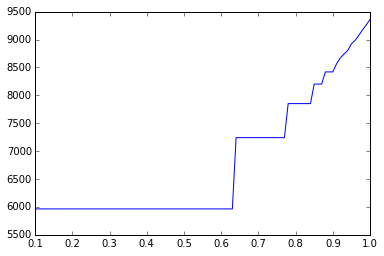

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0 1277    0    0    0    0    0    0
    0    0    0    0    0    0    0  610    0    0    0    0    0    0  350
    0    0  218    0    0  144  105   70   64  121   63   87  101   89   95]
[(0.64, 7241), (0.78, 7851), (0.85, 8201), (0.88, 8419), (0.91, 8563), (0.92, 8668), (0.93, 8738), (0.94, 8802), (0.95, 8923), (0.96, 8986), (0.97, 9073), (0.98, 9174), (0.99, 9263), (1.0, 9358)]
[(1.0, 9358), (0.99, 9263), (0.98, 9174), (0.97, 9073), (0.96, 8986), (0.95, 8923), (0.94, 8802), (0.93, 8738), (0.92, 8668), (0.91, 8563), (0.88, 8419), (0.85, 8201), (0.78, 7851), (0.64, 7241)]


In [112]:

import os
dir_path = os.getcwd() + '/'
with open(dir_path + 'config.txt', 'rb') as f_conf:
    config = json.load(f_conf)
    f_conf.close()
    
sample_file = config["sample_file"] #first input
temp_path = config["temp_path"]

import json
with open(temp_path + 'AW_test.txt', "rb") as f_temp:
    aw_len_list = json.load(f_temp)
print aw_len_list

import matplotlib.pyplot as plt
#plt.plot(aw_len_list)
plt.plot(*zip(*aw_len_list))
plt.show()
idx = zip(*aw_len_list)[0]
aw_len = zip(*aw_len_list)[1]
slope = np.diff(aw_len[::1])
print slope
sc = [(idx[i+1], aw_len[i+1]) for i, x in enumerate(slope) if x != 0]
print sc
print sc[::-1]

In [ ]:
def loosen_by_sc(aw_len_list, show=False):
    "get slope change point from high to low"
    
    idx = zip(*aw_len_list)[0]
    aw_len = zip(*aw_len_list)[1]
    slope = np.diff(aw_len[::1])
    sc = [(idx[i+1], aw_len[i+1]) for i, x in enumerate(slope) if x != 0]
    if show:
        plt.plot(*zip(*aw_len_list)) 
        plt.show()
        print slope
        print sc
    return sc[::-1]

In [ ]:
%%pypy 
## using pypy magic needs a temp file for output 
import json
import numpypy as np # while at sweslos' centos6.x
import time

def count_dict(sample_dict_jieba):
    from collections import Counter
    from collections import OrderedDict
    import itertools
    ptt_pushes_freq_bypush = {}
    for uid, push_list in sample_dict_jieba.iteritems():
        push = push_list[0] #raw push
        a = zip(*push_list)[1] #jieba ones
        push_gram = list(itertools.chain(*a))
        count = Counter(push_gram)
        temp = []
        for w, c in count.most_common():
            temp.append((w, c))
        id_count = Counter(dict(temp))
        ptt_pushes_freq_bypush[uid] = dict(id_count)

    return ptt_pushes_freq_bypush

def weighted_jaccard(l1, l2):
    if len(l1) != len(l2):
        return -1
    num = 0
    den = 0
    for i in xrange(len(l1)):
        num += np.minimum(l1[i], l2[i])
        den += np.maximum(l1[i], l2[i])
    wj = np.divide(np.float64(num), den+1)

    return wj

import os
dir_path = os.getcwd() + '/'
with open(dir_path + 'config.txt', 'rb') as f_conf:
    config = json.load(f_conf)
    f_conf.close()
    
sample_file = config["sample_file"] #first input
temp_path = config["temp_path"] 
result_dir = config["result_dir"]

## just pick some user here from temp folder
with open(temp_path + os.path.splitext(sample_file)[0] + '_userlist.txt', 'rb') as f_temp:
    print 'read user from ', temp_path + os.path.splitext(sample_file)[0] + '_userlist.txt'
    user_list = json.load(f_temp)
    f_temp.close()

with open(temp_path + os.path.splitext(sample_file)[0] + '_cvlist.txt', 'rb') as f_temp:
    print 'read push from', temp_path + os.path.splitext(sample_file)[0] + '_cvlist.txt'
    temp_json = json.load(f_temp)
    f_temp.close()
    

dict_train, dict_test = temp_json # train/test push list for each user

dict_train_count = count_dict(dict_train) #count the freq
dict_test_count = count_dict(dict_test) #count the freq for ans(test)

from collections import Counter
count_all = Counter()
for v in dict_train_count.values():
    count_all += Counter(v)

from collections import OrderedDict
sorted_tuple_list_train_count = OrderedDict(sorted(dict(count_all).items(), key=lambda t: t[1], reverse=True))
## global term count using train data

# with open(temp_path + os.path.splitext(sample_file)[0] + '_train_count.txt', 'wb') as f_temp:
#     f_temp.write(json.dumps(dict_train_count, indent=2, ensure_ascii=True).encode('utf-8'))
#     f_temp.close()

################

##test function

#################Feature Extraction##########################

def AW(dict_train_count, W_PERCENT): #content word

    from collections import Counter
    count_all = Counter()
    for v in dict_train_count.values():
        count_all += Counter(v)

    from collections import OrderedDict
    tlist = OrderedDict(sorted(dict(count_all).items(), key=lambda t: t[1], reverse=True))
    #sorted_tuple_list_train_count
    ##gen sw (but only from training data)
    word = tlist.keys()
    #print dict(sorted_tuple_list_train_count)
    #W_PERCENT = 0.025 #0.025
    ## setting for stopword & rareword percentage
    author_words = [x for x in word if tlist[x] <= tlist[word[int(len(word) * (1-W_PERCENT))]]] #0.975

    ## stop word list
    aw_list = [x for x in author_words] 
    ## rare word list
    #rw_list = [x for x in rarewords] 
    print 'total word', len(word)
    print 'rare word', len(aw_list)
    #print 'rare word', len(rw_list)


    aw_count_dict = {}
    for w in aw_list:
        aw_count_dict.setdefault(len(w),[]).append(w)


    j = {}
    K_NUMWORD = 6 #6
    selected_aw = []
    for k in aw_count_dict.keys()[0:K_NUMWORD]:
        print 'num_word:',k,'\t',len(aw_count_dict[k])
        #j[k] = aw_count_dict[k]
        #print json.dumps(j[1])
        selected_aw += aw_count_dict[k]
    print len(selected_aw)
    
    return selected_aw

selected_aw = AW(dict_train_count, 0.025)
print len(selected_aw)
    

# with open('./feature_pool/' + 'CW.txt', 'wb') as f_feature:
#     f_feature.write(json.dumps(selected_cw, indent=2, ensure_ascii=True).encode('utf-8'))
#     f_feature.close()

###############VEC TIME##########################################

## 2. gen aw vec
import itertools
general_vec = {}
for uid in user_list: # for each user id
    user_len = sum([len(x) for x in dict_train_count[uid]]) #total word freq
    if user_len > 0:
        vec = [dict_train_count[uid].get(w, 0) for w in selected_aw]
        g_vec = [float(x) / user_len for x in vec]
        general_vec[uid] = g_vec


general_vec_ans = {}
for uid in user_list: # for each user id
    user_len = sum([len(x) for x in dict_test_count[uid]]) #total word freq
    #print sum(v.values())
    if user_len > 0:
        vec = [dict_test_count[uid].get(w, 0) for w in selected_aw]
        g_vec = [float(x) / user_len for x in vec]
        general_vec_ans[uid] = g_vec

# print user_list[0]
# print general_vec[user_list[0]]
# print general_vec_ans[user_list[0]]




t_start = time.time()

user_size = len(user_list)
print user_size

sim_list = np.array(np.arange(user_size*user_size))
sim_list = sim_list.astype(float)
print '...'
idx = 0
for i in xrange(user_size):
    for j in xrange(user_size):
        #wj_sw = weighted_jaccard(general_vec[user_list[i]], general_vec_ans[user_list[j]])
        #sim_list = np.vstack((sim_list, np.array((round(float(i),1), round(float(j),1), wj_sw))))
        sim_list[idx] = weighted_jaccard(general_vec[user_list[i]], general_vec_ans[user_list[j]])
        idx += 1
sim_list = sim_list[:idx]
t_stop = time.time()
print 'sim compare time = ', t_stop - t_start, 's'

user_sim_list = []
idx = 0
for i in xrange(user_size):
    for j in xrange(user_size):
        sim = sim_list[idx]
        idx += 1
        user_sim_list.append((user_list[int(i)], user_list[int(j)] + 'ANS', sim))
with open(result_dir + os.path.splitext(sample_file)[0] + '_cv.txt', 'wb') as fout:
    resultpath = result_dir + os.path.splitext(sample_file)[0] + '_cv.txt'
    print 'write to ', resultpath 
    for user, ans, sim in user_sim_list:
        line = user + ',' + ans + ',' + str(sim) +'\n'
        fout.write(line.encode('utf-8'))
    fout.close()


read user from  ./temp/select_pushes1000_1_userlist.txt
read push from ./temp/select_pushes1000_1_cvlist.txt
total word 9507
rare word 6073
num_word: 1 	447
num_word: 2 	4048
num_word: 3 	991
num_word: 4 	394
num_word: 5 	50
num_word: 6 	34
5964
5964
718
...
sim compare time =  8.23145008087 s
write to  ./cv_result/select_pushes1000_1_cv.txt


In [202]:
%%pypy
import numpypy as np # while at sweslos' centos6.x

## using pypy magic needs a temp file for output 
import json
import time
import math
import os


def count_dict(sample_dict_jieba):
    from collections import Counter
    from collections import OrderedDict
    import itertools
    ptt_pushes_freq_bypush = {}
    for uid, push_list in sample_dict_jieba.iteritems():
        push = push_list[0] #raw push
        a = zip(*push_list)[1] #jieba ones
        push_gram = list(itertools.chain(*a))
        count = Counter(push_gram)
        temp = []
        for w, c in count.most_common():
            temp.append((w, c))
        id_count = Counter(dict(temp))
        ptt_pushes_freq_bypush[uid] = dict(id_count)

    return ptt_pushes_freq_bypush

def weighted_jaccard(l1, l2):
    if len(l1) != len(l2):
        return -1
    num = 0
    den = 0
    for i in xrange(len(l1)):
        num += np.minimum(l1[i], l2[i])
        den += np.maximum(l1[i], l2[i])
    wj = np.divide(np.float64(num), den+1)

    return wj

import os
dir_path = os.getcwd() + '/'
with open(dir_path + 'config.txt', 'rb') as f_conf:
    config = json.load(f_conf)
    f_conf.close()
    
sample_file = config["sample_file"] #first input
temp_path = config["temp_path"] 
result_dir = config["result_dir"]

## just pick some user here from temp folder
with open(temp_path + os.path.splitext(sample_file)[0] + '_userlist.txt', 'rb') as f_temp:
    print 'read user from ', temp_path + os.path.splitext(sample_file)[0] + '_userlist.txt'
    user_list = json.load(f_temp)
    f_temp.close()

with open(temp_path + os.path.splitext(sample_file)[0] + '_cvlist.txt', 'rb') as f_temp:
    print 'read push from', temp_path + os.path.splitext(sample_file)[0] + '_cvlist.txt'
    temp_json = json.load(f_temp)
    f_temp.close()
    

dict_train, dict_test = temp_json # train/test push list for each user

dict_train_count = count_dict(dict_train) #count the freq
dict_test_count = count_dict(dict_test) #count the freq for ans(test)

from collections import Counter
count_all = Counter()
for v in dict_train_count.values():
    count_all += Counter(v)

from collections import OrderedDict
sorted_tuple_list_train_count = OrderedDict(sorted(dict(count_all).items(), key=lambda t: t[1], reverse=True))
## global term count using train data

# with open(temp_path + os.path.splitext(sample_file)[0] + '_train_count.txt', 'wb') as f_temp:
#     f_temp.write(json.dumps(dict_train_count, indent=2, ensure_ascii=True).encode('utf-8'))
#     f_temp.close()

################

##test function

#################Feature Extraction##########################

def loosen_AW(dict_train_count, begin, itvl, K_NUMWORD=6, show=False):
    ###if need to show, don't use pypy (pypy can't plot)
    
    def _get_aw(tlist, word, wp, K_NUMWORD):
        W_PERCENT = wp
        author_words = [x for x in word if tlist[x] >= tlist[word[int(len(word) * (1-W_PERCENT))]]] #0.975
        ## stop word list
        aw_list = [x for x in author_words] 
        aw_count_dict = {}
        for w in aw_list:
            aw_count_dict.setdefault(len(w),[]).append(w)
        j = {}
        K_NUMWORD = 3 #6
        selected_aw = []
        for k in aw_count_dict.keys()[0:K_NUMWORD]:
            #print 'num_word:',k,'\t',len(aw_count_dict[k])
            selected_aw += aw_count_dict[k]
        #print 'words (selected / rare / total)', len(selected_aw), '/', len(aw_list), '/', len(word) 
        return selected_aw

    def _get_ans_by_sim(sorted_usl, lt_value):
        LT_VALUE = lt_value
        return sum(sim > LT_VALUE and user_i+'ANS' == user_j for user_i, user_j, sim in sorted_usl)
    
    def _get_user_by_sim(sorted_usl, lt_value):
        LT_VALUE = lt_value
        return sum(sim > LT_VALUE for sim in zip(*sorted_usl)[2])
    

    ##get all word count
    from collections import Counter
    count_all = Counter()
    for v in dict_train_count.values():
        count_all += Counter(v)
    from collections import OrderedDict
    tlist = OrderedDict(sorted(dict(count_all).items(), key=lambda t: t[1], reverse=True))
    
    word = tlist.keys()
    
    
    #touch W_PERCENT
    aw_len_list = []
    for wp in np.arange(begin, 1.0 + itvl, itvl):
        selected_aw = _get_aw(tlist, word, wp, K_NUMWORD)
        #selected_aw = selected_aw[0: len(selected_aw)/2]
        aw_len_list.append((wp,len(selected_aw), selected_aw))
        "get slope change point from high to low"
    wp = zip(*aw_len_list)[0]
    aw_len = zip(*aw_len_list)[1]
    aw_list = zip(*aw_len_list)[2]
    
    #get gradient slope
    slope = []
    for i in xrange(1, len(aw_len)):
        slope.append(aw_len[i] - aw_len[i-1])
    sc = [(wp[i], aw_len[i], aw_list) for i, x in enumerate(slope) if x != 0]
    
    #check the graph
    if show:
        plt.plot(*zip(*aw_len_list)) 
        plt.show()
        print slope
        print sc
    return sc

ls_AW = loosen_AW(dict_train_count, 0.6, 0.05)


dirfmt = "simlist_%4d-%02d-%02d_%02d%02d"
now = time.localtime()[0:5]
dirname = dirfmt % now
loosen_dir = result_dir + dirname
os.mkdir(loosen_dir)

for wp, aw, aw_list in ls_AW:
    general_vec = {}
    for uid in user_list: # for each user id
        user_len = sum([len(x) for x in dict_train_count[uid]]) #total word freq
        if user_len > 0:
            vec = [dict_train_count[uid].get(w, 0) for w in aw_list[0]] #aw_list[0] is bug
            g_vec = [float(x) / user_len for x in vec]
            general_vec[uid] = g_vec


    general_vec_ans = {}
    for uid in user_list: # for each user id
        user_len = sum([len(x) for x in dict_test_count[uid]]) #total word freq
        #print sum(v.values())
        if user_len > 0:
            vec = [dict_test_count[uid].get(w, 0) for w in aw_list[0]]
            g_vec = [float(x) / user_len for x in vec]
            general_vec_ans[uid] = g_vec

    # print user_list[0]
    # print general_vec[user_list[0]]
    # print general_vec_ans[user_list[0]]


    t_start = time.time()

    user_size = len(user_list)
    #print user_size

    sim_list = np.array(np.arange(user_size*user_size))
    sim_list = sim_list.astype(float)
    print '-------'
    
    idx = 0
    for i in xrange(user_size):
        for j in xrange(user_size):
            #wj_sw = weighted_jaccard(general_vec[user_list[i]], general_vec_ans[user_list[j]])
            #sim_list = np.vstack((sim_list, np.array((round(float(i),1), round(float(j),1), wj_sw))))

            sim_list[idx] = weighted_jaccard(general_vec[user_list[i]], general_vec_ans[user_list[j]])
            idx += 1
    sim_list = sim_list[:idx]
    t_stop = time.time()
    #print sim_list
    #print 'sim compare time = ', t_stop - t_start, 's'

    user_sim_list = []
    idx = 0
    for i in xrange(user_size):
        for j in xrange(user_size):
            sim = sim_list[idx]
            idx += 1
            if str(sim) == '0.0':
                continue
            user_sim_list.append((user_list[int(i)], user_list[int(j)] + 'ANS', sim))
    
    from operator import itemgetter 
    sorted_usl = sorted(user_sim_list, key=itemgetter(2), reverse=True)
    def _get_ans_by_sim(sorted_usl, lt_value):
        LT_VALUE = lt_value
        return sum(sim > LT_VALUE and user_i+'ANS' == user_j for user_i, user_j, sim in sorted_usl)
    
    def _get_user_by_sim(sorted_usl, lt_value):
        LT_VALUE = lt_value
        return sum(sim > LT_VALUE for sim in zip(*sorted_usl)[2])
    #print 'lt:0.00000', _get_ans_by_sim(sorted_usl, 0) , _get_user_by_sim(sorted_usl, 0)
    print 'Num of aw words:', aw
    for n in range(1,6):
        lt = float('0.'+ str(n))
        print 'lt:', lt, _get_ans_by_sim(sorted_usl, lt) , _get_user_by_sim(sorted_usl, lt)
    
    #name = os.path.splitext(sample_file)[0]
    resultpath = loosen_dir + '/' + os.path.splitext(sample_file)[0] + '_cv' + str(wp) + '.txt'
    with open(resultpath, 'wb') as fout:
        
        print 'write to ', resultpath 
        for user, ans, sim in sorted_usl:
            line = user + ',' + ans + ',' + str(sim) +'\n'
            fout.write(line.encode('utf-8'))
        fout.close()
    

read user from  ./temp/select_pushes1000_1_userlist.txt
read push from ./temp/select_pushes1000_1_cvlist.txt
-------
Num of aw words: 8792
lt: 0.1 215 3309
lt: 0.2 62 226
lt: 0.3 30 50
lt: 0.4 20 21
lt: 0.5 2 2
write to  ./cv_result/simlist_2015-07-15_1204/select_pushes1000_1_cv0.6.txt
-------
Num of aw words: 3306
lt: 0.1 215 3309
lt: 0.2 62 226
lt: 0.3 30 50
lt: 0.4 20 21
lt: 0.5 2 2
write to  ./cv_result/simlist_2015-07-15_1204/select_pushes1000_1_cv0.75.txt
-------
Num of aw words: 2082
lt: 0.1 215 3309
lt: 0.2 62 226
lt: 0.3 30 50
lt: 0.4 20 21
lt: 0.5 2 2
write to  ./cv_result/simlist_2015-07-15_1204/select_pushes1000_1_cv0.8.txt
-------
Num of aw words: 1488
lt: 0.1 215 3309
lt: 0.2 62 226
lt: 0.3 30 50
lt: 0.4 20 21
lt: 0.5 2 2
write to  ./cv_result/simlist_2015-07-15_1204/select_pushes1000_1_cv0.85.txt
-------
Num of aw words: 1142
lt: 0.1 215 3309
lt: 0.2 62 226
lt: 0.3 30 50
lt: 0.4 20 21
lt: 0.5 2 2
write to  ./cv_result/simlist_2015-07-15_1204/select_pushes1000_1_cv0.9.txt